<a href="https://colab.research.google.com/github/laurenneal/capstone-visual-neuroscience/blob/Dylan/get_matlab_results_and_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


From Carl's Document:

After extraction, data is saved in DATA/leprechaunROI, in dated folders matching the dated folders in DATA/leprechaunMat, and with fly index in the filename. 

I’ve included an example of extraction of the example recording in leprechaunMat 

Within the dated folders will be two files per recording, suffixes ‘roiData’ and ‘cNMF’. The data in file ‘cNMF’ is just a subset of the data in file ‘roiData’, so you can ignore file ‘cNMF’ for now. 

File ‘roiData’ has a variable called roiStruct, which has several fields. 
* roiStruct.bwMask is a 2d array matching xy size of stackRaw, and is a mask of ones and zeros, ones located in pixels where rois have been identified    
* roiStruct.bsMaskStack is a 3d array, size of 3rd dimension matches number of extracted rois, and each slice in the 3rd dimension is the same size as bwMask, with ones located in the pixels assigned the roi whose number matches the index of the 3rd dimension (ie roiStruct.bwMask = sum(roiStruct.bwMaskStack,3))
* roiStruct.bwLabel is the same size as bwMask but has the roiNumber where each roi is located (this is ultimately the most important output from the extraction). You can see what the rois look like with the following command: imagesc(roiStruct.bwLabel)  

File roiData has a variable called imagingStruct, which shows all stacks (one per row) and is only different from the imagingStruct in file ‘imagingStruct’ in that the field ‘imagingStruct.stackRaw’ has collapsed the xy dimensions into a single ‘pixel’ representing a roi. This means what was 128 by 256 by time is now 1 by number_rois by time. So, for example, you can plot the fluorescence within roi 5 across the first 500 indices of stack 2 with the following command:

plot(squeeze(imagingStruct(2).stackRaw(1,5,1:500)))

These will be the timeseries we use to assess quality of extraction 


In [2]:
# this is the path where the data is stored.
! ls drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/leprechaunROI/210802.0.cfrw/210802.0.cfrw_fly0_ch1_6H29_g4_mix-sytGCaMP6f_v5,ch2_6H29_g4_mix-sytGCaMP6f_v5,rec_hsflpg80_x3,age_9_imagingStruct,roiStruct-20210916T223532-1-cNMF_roiData.mat

drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/leprechaunROI/210802.0.cfrw/210802.0.cfrw_fly0_ch1_6H29_g4_mix-sytGCaMP6f_v5,ch2_6H29_g4_mix-sytGCaMP6f_v5,rec_hsflpg80_x3,age_9_imagingStruct,roiStruct-20210916T223532-1-cNMF_roiData.mat


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
f_name = 'drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/leprechaunROI/210802.0.cfrw/210802.0.cfrw_fly0_ch1_6H29_g4_mix-sytGCaMP6f_v5,ch2_6H29_g4_mix-sytGCaMP6f_v5,rec_hsflpg80_x3,age_9_imagingStruct,roiStruct-20210916T223532-1-cNMF_roiData.mat'

#read file in using hdf5 structure
h = h5py.File(f_name,'r')


In [59]:
#traverse the file structure and see what's in there
def foo(name, obj):
   print(name, obj)
   return None

h.visititems(foo)

#refs# <HDF5 group "/#refs#" (352 members)>
#refs#/0 <HDF5 dataset "0": shape (13, 1), type "<u2">
#refs#/0b <HDF5 dataset "0b": shape (22, 1), type "<u2">
#refs#/0c <HDF5 dataset "0c": shape (14, 1), type "<u2">
#refs#/0d <HDF5 dataset "0d": shape (1, 1), type "<f8">
#refs#/0e <HDF5 dataset "0e": shape (8, 1), type "<u2">
#refs#/1 <HDF5 dataset "1": shape (2, 1), type "<u2">
#refs#/1b <HDF5 dataset "1b": shape (5, 1), type "<u2">
#refs#/1c <HDF5 dataset "1c": shape (3, 1), type "<u2">
#refs#/1d <HDF5 dataset "1d": shape (1, 1), type "<f8">
#refs#/1e <HDF5 dataset "1e": shape (6, 1), type "<u2">
#refs#/2 <HDF5 dataset "2": shape (2, 1), type "<u2">
#refs#/2b <HDF5 dataset "2b": shape (5, 1), type "<u2">
#refs#/2c <HDF5 dataset "2c": shape (3, 1), type "<u2">
#refs#/2d <HDF5 dataset "2d": shape (1, 1), type "<f8">
#refs#/2e <HDF5 dataset "2e": shape (8, 1), type "<u2">
#refs#/3 <HDF5 dataset "3": shape (2, 1), type "<u2">
#refs#/3b <HDF5 dataset "3b": shape (8, 1), type "<u2">
#refs#/3c

In [36]:
#list the three main folders
list(h.keys())

['#refs#', 'imagingStruct', 'roiInfo', 'roiStruct']

In [16]:
#Access what's inside 'roiStruct'
roiStruct = h['roiStruct']
list(roiStruct.keys())

['bwLabel',
 'bwMask',
 'bwMaskStack',
 'fileName',
 'fileNameSuffix',
 'nROIs',
 'roiType',
 'stackInd',
 'uniqueID']

In [19]:
# stack of each roi's footprints - we'll use each of these
bwLabelStack = roiStruct['bwMaskStack']
bwLabelStack.shape

(35, 256, 128)

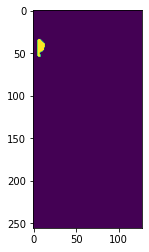

In [147]:
#plot the first roi
dims = [256, 128]
#save to variable
spatial = bwLabelStack[0][:]
plt.imshow(np.reshape(spatial, dims, order="F"))

I can't figure out how to access imagingStruct.stackRaw data using h5py - within stackRaw are 3 h5 reference objects that I can't get into. Trying a different method

In [110]:
!pip install mat73
import mat73
data_dict = mat73.loadmat('drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/leprechaunROI/210802.0.cfrw/210802.0.cfrw_fly0_ch1_6H29_g4_mix-sytGCaMP6f_v5,ch2_6H29_g4_mix-sytGCaMP6f_v5,rec_hsflpg80_x3,age_9_imagingStruct,roiStruct-20210916T223532-1-cNMF_roiData.mat')

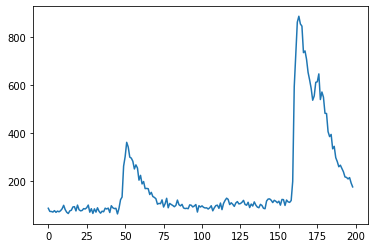

In [139]:
#The first 10 seconds worth of frames of the first roi in the first stack
#inside stackRaw are three lists of lists, one for each stack in this results set
#we're interested in the first stack, then the first roi, so [0][0]

temporal = data_dict['imagingStruct']['stackRaw'][0][0][1:200]
plt.plot(temporal)

## We now have 2 variables, spatial and temporal, holding info on one roi

In [140]:
#We can generate summary metrics of the temporal feature

mean = np.mean(temporal)
print(f'mean fluorescence: {mean}')

max = np.max(temporal)
print(f'max fluorescence: {max}')

min = np.min(temporal)
print(f'min fluorescence: {min}')

stdev = np.std(temporal)
print(f'stdev of fluorescence: {stdev}')

#probably other meaningful measures here

mean fluorescence: 186.8612337761604
max fluorescence: 888.6276315219144
min fluorescence: 62.32207081817142
stdev of fluorescence: 183.81583491621294


In [181]:
# spatial features are more difficult


area = np.sum(spatial) #sum of positive pixels is the area because the labels are binary
print(f'area: {area}')

#where in the FOV is the neuron? Get coordinates of its center of mass

from scipy import ndimage
#format the spatial footprint matrix back into image format
spatial_img = np.reshape(spatial, dims, order="F")
#nice package to calculate row and column for center of mass of an object (I think this assumes single continuous area)
#https://stackoverflow.com/questions/33707095/how-to-locate-a-particular-region-of-values-in-a-2d-numpy-array?answertab=active#tab-top
#measured in (rows from the top, columns from the left)
center_of_mass_row, center_of_mass_column = ndimage.center_of_mass(spatial_img)
print(center_of_mass_row, center_of_mass_column)

#get perimeter of the roi (I think this assumes a single continuous area as well)
!pip install scikit-image
import skimage
perimeter = skimage.measure.perimeter(spatial_img)


area: 132.0
43.02272727272727 8.106060606060606


## extract these features from each roi in the file

In [186]:
from scipy import ndimage
!pip install scikit-image
import skimage
import pandas as pd

roi_features = pd.DataFrame(columns =['roi_number',
                                      'area',
                                      'center_of_mass_row',
                                      'center_of_mass_column',
                                      'perimeter',
                                      'mean_fl',
                                      'max_fl',
                                      'min_fl',
                                      'stdev_fl'])

#loop through rois and extract features - these have not been validated to be calculated correctly
for x in range(len(bwLabelStack)):
  spatial = bwLabelStack[x] #spatial footprint of the x'th roi
  temporal = data_dict['imagingStruct']['stackRaw'][0][x][1:200] #first 200 frames of data for the roi

  #calculate spatial measures
  area = np.sum(spatial)

  spatial_img = np.reshape(spatial, dims, order="F")
  center_of_mass_row, center_of_mass_column = ndimage.center_of_mass(spatial_img)
  perimeter = skimage.measure.perimeter(spatial_img)


  #calculate temporal measures
  mean = np.mean(temporal)
  max = np.max(temporal)
  min = np.min(temporal)
  stdev = np.std(temporal)

  roi_features = roi_features.append({'roi_number': x,
                                      'area': area,
                                      'center_of_mass_row': center_of_mass_row,
                                      'center_of_mass_column': center_of_mass_column,
                                      'perimeter': perimeter,
                                      'mean_fl': mean,
                                      'max_fl': max,
                                      'min_fl': min,
                                      'stdev_fl': stdev}, ignore_index=True)

,roi_number,area,center_of_mass_row,center_of_mass_column,perimeter,mean_fl,max_fl,min_fl,stdev_fl
0,0.0,132.0,43.022727,8.106061,50.384776,186.861234,888.627632,62.322071,183.815835
1,1.0,29.0,190.206897,94.241379,17.899495,765.751361,1797.844589,160.181869,393.897759
2,2.0,210.0,105.695238,56.423810,70.526912,294.874329,569.455995,142.267544,81.365754
3,3.0,73.0,204.027397,92.219178,41.213203,160.149062,531.733226,43.179160,92.904350
4,4.0,26.0,34.038462,10.153846,18.485281,177.498624,672.989617,50.460631,113.036314
5,5.0,194.0,104.015464,86.185567,73.012193,388.306819,792.153484,170.175662,144.781999
6,6.0,82.0,46.792683,27.524390,37.899495,142.340530,529.627213,81.451275,83.219691
7,7.0,28.0,32.500000,103.500000,16.485281,276.738441,668.814502,98.597979,147.381463
8,8.0,120.0,97.183333,23.000000,53.112698,775.515200,1546.047824,313.695315,249.351017
9,9.0,192.0,175.567708,42.348958,63.597980,185.752789,685.605769,100.533867,104.520724


In [187]:
roi_features

,roi_number,area,center_of_mass_row,center_of_mass_column,perimeter,mean_fl,max_fl,min_fl,stdev_fl
0,0.0,132.0,43.022727,8.106061,50.384776,186.861234,888.627632,62.322071,183.815835
1,1.0,29.0,190.206897,94.241379,17.899495,765.751361,1797.844589,160.181869,393.897759
2,2.0,210.0,105.695238,56.423810,70.526912,294.874329,569.455995,142.267544,81.365754
3,3.0,73.0,204.027397,92.219178,41.213203,160.149062,531.733226,43.179160,92.904350
4,4.0,26.0,34.038462,10.153846,18.485281,177.498624,672.989617,50.460631,113.036314
5,5.0,194.0,104.015464,86.185567,73.012193,388.306819,792.153484,170.175662,144.781999
6,6.0,82.0,46.792683,27.524390,37.899495,142.340530,529.627213,81.451275,83.219691
7,7.0,28.0,32.500000,103.500000,16.485281,276.738441,668.814502,98.597979,147.381463
8,8.0,120.0,97.183333,23.000000,53.112698,775.515200,1546.047824,313.695315,249.351017
9,9.0,192.0,175.567708,42.348958,63.597980,185.752789,685.605769,100.533867,104.520724
